In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

# Load data

In [2]:
seed = 9033

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
print('Loading data')
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample = 1.0,
                                                    propn_labeled = 0.1)

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=20,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=100,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break


print('Done.')

Loading data
Done.


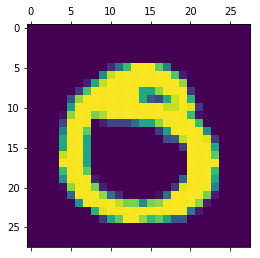

In [4]:
plt.matshow(data_labeled['image'][0, :, :])

In [5]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [6]:
latent_dim = 5
n_classes = 10

In [7]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [8]:
# Load results

enc_file = "../mnist_vae_results_aws/mnist_vae4_semisupervised_enc_final"
dec_file = '../mnist_vae_results_aws/mnist_vae4_semisupervised_dec_final'
classifier_file = '../mnist_vae_results_aws/mnist_vae4_semisupervised_classifier_final100'
vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=784, bias=True)
    (fc5): Linear(in_features=784, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1568, bias=True)
  )
)

In [9]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=784, bias=True)
    (fc5): Linear(in_features=784, out_features=10, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=15, out_features=784, bias=True)
    (fc2): Linear(in_features=784, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1568, bias=True)
  )
)>


In [10]:
loss_array = np.loadtxt('../mnist_vae_results_aws/mnist_vae4_semisupervisedloss_array.txt')

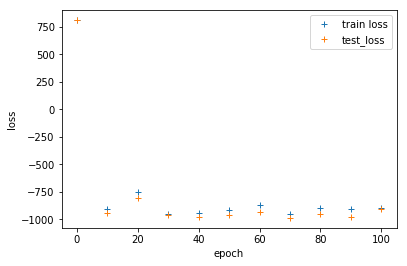

In [11]:
plt.plot(loss_array[0, :], loss_array[1, :], '+')
plt.plot(loss_array[0, :], loss_array[2, :], '+')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

In [12]:
vae.loss(data_unlabeled['image'])[0]

tensor(-926.9976)

In [13]:
vae.loss(test_data['image'])[0]

tensor(-851.2202)

In [14]:
# check a few train images

In [15]:
class_weights = vae.classifier(data_unlabeled['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = common_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

latent_means, latent_std, latent_samples = \
    vae.encoder_forward(data_unlabeled['image'], z_ind_one_hot)

    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind_one_hot)

In [16]:
class_weights

tensor([[ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
          0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
          0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
          0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
          0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
          0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
          0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
          0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
          0.1000,  0.1000,  0.1000],
        [ 0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,  0.1000,
          0.1000,  0.1000,  0.1000],
        [ 0.1000,  

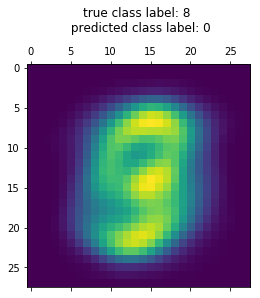

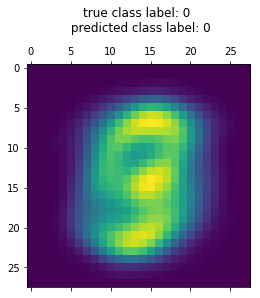

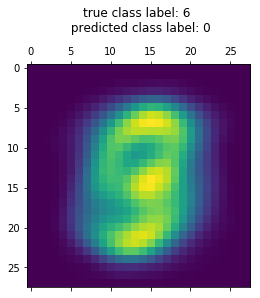

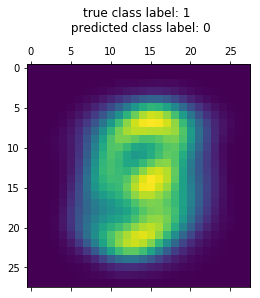

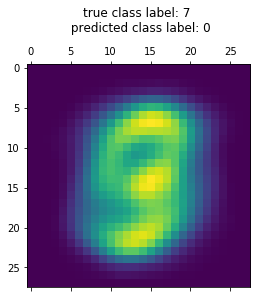

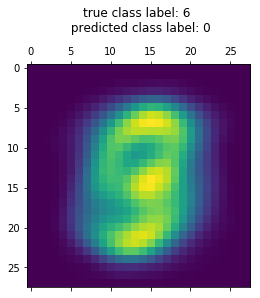

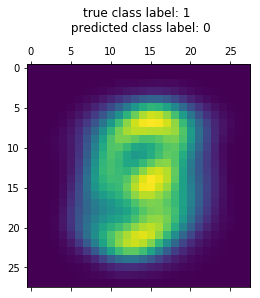

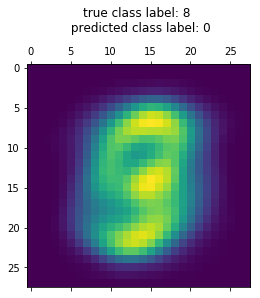

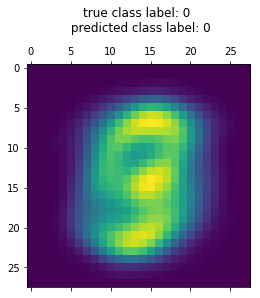

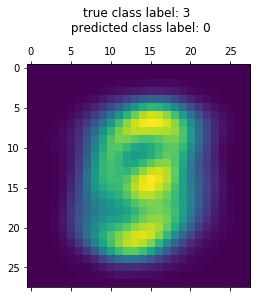

In [17]:
for i in range(10): 
    plt.matshow(image_mu[i, :, :].detach())
    plt.title('true class label: {} \n predicted class label: {}\n'.format(data_unlabeled['label'][i], z_ind[i]))

In [18]:
# check a few test images 

In [19]:
class_weights = vae.classifier(test_data['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = common_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

latent_means, latent_std, latent_samples = \
    vae.encoder_forward(data_unlabeled['image'], z_ind_one_hot)

    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind_one_hot)

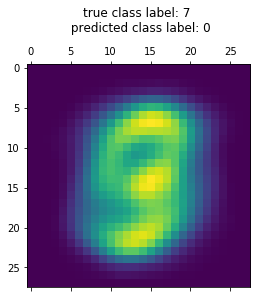

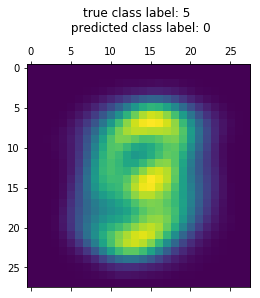

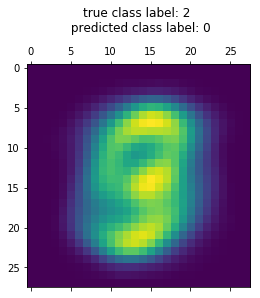

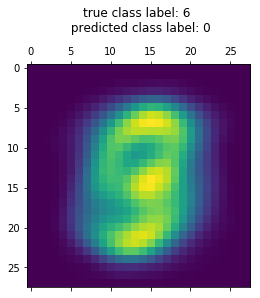

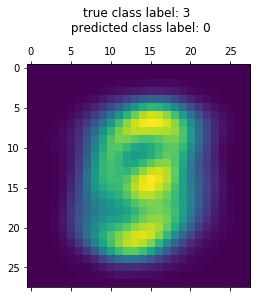

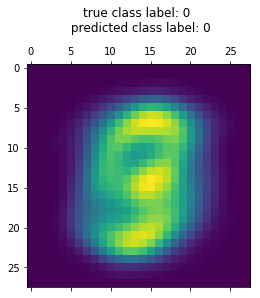

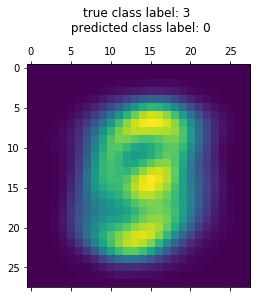

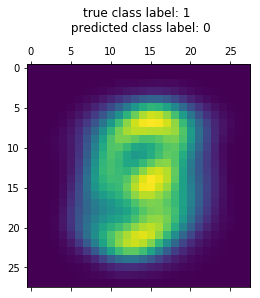

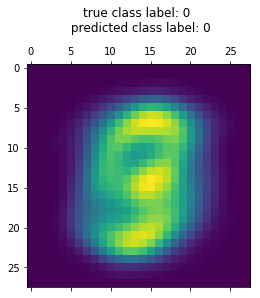

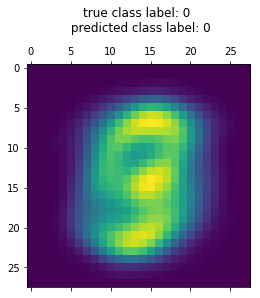

In [20]:
for i in range(10): 
    plt.matshow(image_mu[i, :, :].detach())
    plt.title('true class label: {} \n predicted class label: {}\n'.format(test_data['label'][i], z_ind[i]))

In [22]:
train_loader_unlabeled

In [23]:
image = data_unlabeled['image']

In [28]:
for z in range(vae.n_classes):
    batch_z = torch.ones(image.shape[0]) * z

    image_mu, image_std, latent_means, latent_std, latent_samples = \
        vae.forward_conditional(image, batch_z)

    # likelihood term
    normal_loglik_z = common_utils.get_normal_loglik(image, image_mu,
                                            image_std, scale = False)

    print(normal_loglik_z[0])

tensor(855.2313)
tensor(855.2313)
tensor(855.2313)
tensor(855.2313)
tensor(855.2313)
tensor(855.2313)
tensor(855.2313)
tensor(855.2313)
tensor(855.2313)
tensor(855.2313)
